## 1. Problem
Cookie Cats 是一款拼圖手機遊戲。
設計遊戲時，偶而會設置較困難的遊戲關卡，目的為：
- 增加玩家在應用程式的消費
- 卡關能夠延長玩家對遊戲的樂趣。

原本第一個較難的關卡設置在 Lv. 30，**如果將第一個較難的關卡從 Lv. 30 移到 Lv. 40，會對遊戲產生什麼影響嗎？**
- 驗證問題：是否要將第一個較難的關卡從Level 30 移到 Level 40？
- 方法：A/B testing（控制組：Level 30, 對照組：Level 40）
- 指標：玩家的留存率

In [18]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. A/B testing data
資料集包含 90,189 位玩家，這些玩家在 A/B testing 實驗期間下載了 Cookie Cats。

這些玩家下載遊戲時，會被隨機分配到 gate_30（控制組）和 gate_40（對照組）。

資料欄位如下：
- **userid**
- **version**
    - gate_30（控制組）
    - gate_40（對照組）
- **sum_gamerounds**: 玩家在下載 14 天內破關的遊戲關卡
- **retention_1**: 玩家在下載 1 天後是否仍在玩 Cookie Cats
- **retention_7**: 玩家在下載 7 天後是否仍在玩 Cookie Cats

In [20]:
# Counting the number of players in each AB group.
df.groupby(['version']).count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 3. The distribution of game rounds
在做 A/B testing 前，先觀察玩家的破關關數。
從下圖可以看出：
- 有些玩家僅下載遊戲但從來沒有玩過（0 game rounds）
- 有些玩家在第一個禮拜只有玩幾十關
- 有些玩家完全迷上 Cookie Cats 了

Text(0,0.5,'Number of Players for each number of gamerounds')

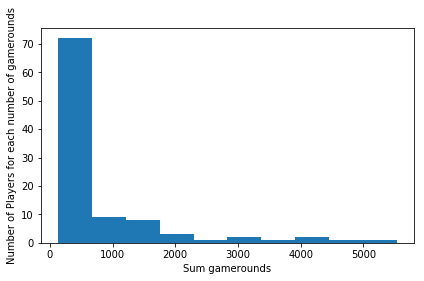

In [22]:
# This command makes plots appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby(['sum_gamerounds'])['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(x="sum_gamerounds", y="userid", kind="hist")
ax.set_xlabel("Sum gamerounds")
ax.set_ylabel("Number of Players for each number of gamerounds")

## 4. Overall 1-day retention
一天留存率（1-day retention）
- 定義：下載遊戲且在一天內且玩了遊戲的玩家數
- 一天留存率越高，表示越容易讓玩家留存並且建立更大的玩家基數

Benchmark：資料集中的玩家下載遊戲後，接近一半（44％）隔天會繼續玩遊戲

In [24]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

由下表可以觀察到：**當關卡障礙從 Lv. 30 移到 Lv. 40 時，一天留存率有些微的降低**

In [26]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 5. Should we be confident in the difference?
Bootstrapping：重複對資料集重採樣（resample），並計算採樣的平均一天留存率。

從圖一我們可以觀察兩組一天留存率的抽樣結果：
- 指標明顯變化，顯示出指標的不確定性
- 整體看來，一天留存率「Lv. 40」略小於「Lv. 30」，但**這個差距顯著嗎？**

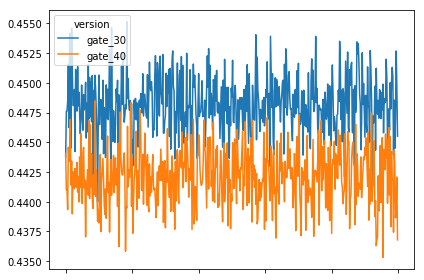

In [28]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot()

## 6. Zooming in on the difference
下圖畫出兩組 Bootstrapping 後的一天留存率百分比差異：
- 約 1%～2%，並且大部分分佈都在 0% 以上
- 96.2 % 的機率一天留存率「Lv. 30」高於「Lv. 40」更好，**表示兩組有顯著的差異。**

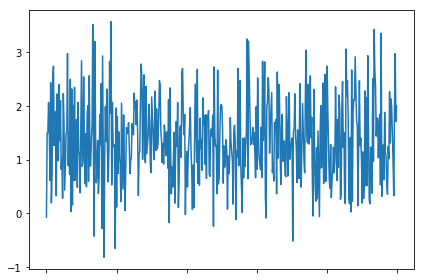

In [30]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot()

In [32]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).mean()

# Pretty printing the probability
print(prob)

0.974


## 7. 7-day retention by AB-group
下圖畫出兩組 Bootstrapping 後的七天留存率百分比差異：
- 整體看來，七天留存率「Lv. 40」也小於「Lv. 30」且差距顯著
- 「七天留存率」低於「一天留存率」且百分比差異「七天留存率」大於 「1 天留存率」
- 安裝後「一周玩遊戲的人」比安裝「一天後玩遊戲的人」少

In [34]:
# Calculating 7-day retention for both AB-groups
df.groupby(['version'])['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

1.0


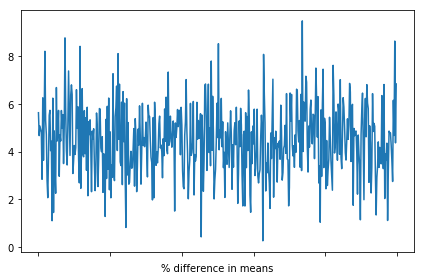

In [36]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()

# Pretty printing the probability
print(prob)

## 8.  The conclusion
- 本次分析以 Bootstrapping 驗證 Lv. 30 和 Lv. 40 在一天和七天的留存率有顯著差異
- 表示如果我們想保持較高的留存率，我們**不應該將第一個較難的關卡從原本的 Lv. 30 移到 Lv. 40。**